# JCC2 User Questionnaire - Executive Summary

This notebook provides a compressed, high-level view of the JCC2 User Questionnaire data, focusing on key metrics and essential visualizations for decision-making.

**Last Updated:** {current_date}

In [10]:
import sys
import os

# Add the parent directory to the path (works in Jupyter notebooks)
sys.path.insert(0, os.path.abspath('..'))

# Import the correct processor module and factory function
from jcc2_data_processor import create_processor

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define consistent color scheme
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e', 
    'success': '#2ca02c',
    'danger': '#d62728',
    'warning': '#ff9800',
    'info': '#17a2b8'
}

In [13]:
# Use the correct path to the data file
data_file = '/home/nathanjgaul/Downloads/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv'

# Initialize processor using the factory function
processor = create_processor(data_file)

# Load data
df = processor.load_data()

# Update date in header
current_date = datetime.now().strftime('%Y-%m-%d')
print(f"Data loaded: {len(df)} responses, {len(df.columns)} fields")
print(f"Date range: {df['user_information.date'].min()} to {df['user_information.date'].max()}")

2025-08-01 15:03:08,240 - INFO - Detected User Questionnaire format
2025-08-01 15:03:08,241 - INFO - Loading data from /home/nathanjgaul/Downloads/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv
2025-08-01 15:03:08,251 - INFO - Parsing field schemas
2025-08-01 15:03:08,260 - INFO - Loaded 21 data rows with 667 columns
2025-08-01 15:03:08,260 - INFO - Found 28 sections and 6 system columns


Data loaded: 21 responses, 667 fields
Date range: 2025-06-23 to 2025-06-25


In [25]:
for section in processor.sections:
    print(section)

user_information
role_and_echelon
operational_jcc2_experience
jcc2_application_usage
mop_1_1_1
mos_1_1_2
mop_1_1_3
reporting_and_data_export
mop_1_1_5
mop_1_2_1
mop_1_2_2
mos_1_3_1
mop_1_3_2
mop_1_3_3
mop_1_3_4
mop_1_3_5
mop_2_1_1
mop_2_1_2
mop_2_1_7
mop_2_1_9
mop_2_3_1
mop_2_3_2
mop_2_4_1
mos_3_2_1
mos_3_2_2
mop_3_2_3
overall_system_usability
overall_system_suitability_eval


## 1. Overall Data Quality & Response Summary


=== OVERALL DATA SUMMARY ===
                 Metric                    Value
        Total Responses                       21
           Total Fields                      667
Average Completion Rate                    35.5%
             Date Range 2025-06-23 to 2025-06-25
          Unique Events                        4
           Unique Units                       14


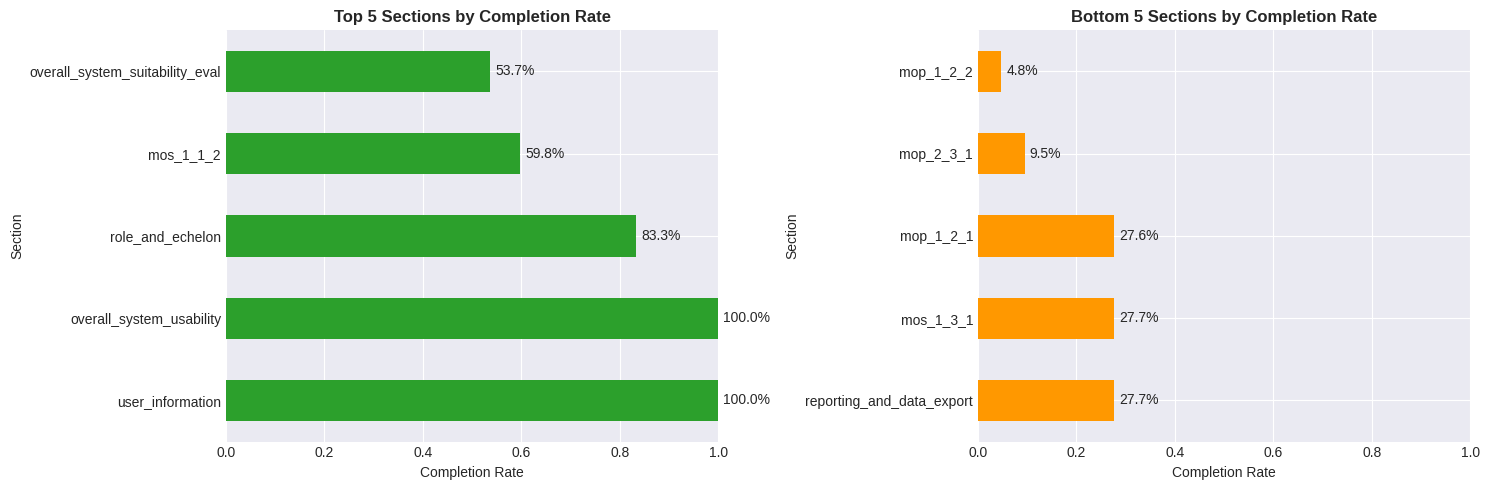

In [14]:
# Create overall metrics summary table
overall_metrics = []

# Basic statistics
overall_metrics.append(['Total Responses', len(df)])
overall_metrics.append(['Total Fields', len(df.columns)])
overall_metrics.append(['Average Completion Rate', f"{df.notna().sum().sum() / (len(df) * len(df.columns)) * 100:.1f}%"])
overall_metrics.append(['Date Range', f"{df['user_information.date'].min()} to {df['user_information.date'].max()}"])

# Participation metrics
if 'user_information.event' in df.columns:
    overall_metrics.append(['Unique Events', df['user_information.event'].nunique()])
if 'user_information.unit' in df.columns:
    overall_metrics.append(['Unique Units', df['user_information.unit'].nunique()])

# Create metrics table
metrics_df = pd.DataFrame(overall_metrics, columns=['Metric', 'Value'])
print("\n=== OVERALL DATA SUMMARY ===")
print(metrics_df.to_string(index=False))

# Quick visualization of response completion by section
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Section completion rates
section_completion = {}
for section_name, fields in processor.sections.items():
    completion_rates = [df[field].notna().mean() for field in fields if field in df.columns]
    if completion_rates:
        section_completion[section_name] = np.mean(completion_rates)

# Top and bottom 5 sections
sorted_sections = sorted(section_completion.items(), key=lambda x: x[1], reverse=True)
top_sections = sorted_sections[:5]
bottom_sections = sorted_sections[-5:]

# Plot top sections
top_df = pd.DataFrame(top_sections, columns=['Section', 'Completion'])
top_df.plot(x='Section', y='Completion', kind='barh', ax=ax1, color=COLORS['success'], legend=False)
ax1.set_title('Top 5 Sections by Completion Rate', fontweight='bold')
ax1.set_xlabel('Completion Rate')
ax1.set_xlim(0, 1)
for i, (_, rate) in enumerate(top_sections):
    ax1.text(rate + 0.01, i, f'{rate:.1%}', va='center')

# Plot bottom sections
bottom_df = pd.DataFrame(bottom_sections, columns=['Section', 'Completion'])
bottom_df.plot(x='Section', y='Completion', kind='barh', ax=ax2, color=COLORS['warning'], legend=False)
ax2.set_title('Bottom 5 Sections by Completion Rate', fontweight='bold')
ax2.set_xlabel('Completion Rate')
ax2.set_xlim(0, 1)
for i, (_, rate) in enumerate(bottom_sections):
    ax2.text(rate + 0.01, i, f'{rate:.1%}', va='center')

plt.tight_layout()
plt.show()

## 2. Section-by-Section Key Metrics

In [15]:
# Define key metrics extractor for each section type
def extract_key_metrics(section_name, fields, df):
    """Extract the most important metrics for a given section."""
    metrics = {}
    
    # Common metrics for all sections
    valid_fields = [f for f in fields if f in df.columns]
    if valid_fields:
        completion_rates = [df[field].notna().mean() for field in valid_fields]
        metrics['Fields'] = len(valid_fields)
        metrics['Avg Completion'] = f"{np.mean(completion_rates):.1%}"
    
    # Section-specific metrics
    if section_name == 'user_information':
        if 'user_information.event' in df.columns:
            metrics['Events'] = df['user_information.event'].nunique()
        if 'user_information.unit' in df.columns:
            metrics['Units'] = df['user_information.unit'].nunique()
    
    elif section_name == 'role_and_echelon':
        if 'role_and_echelon.is_cyber_operator' in df.columns:
            cyber_pct = (df['role_and_echelon.is_cyber_operator'] == 'Yes').mean() * 100
            metrics['Cyber Operators'] = f"{cyber_pct:.1f}%"
        if 'role_and_echelon.echelon' in df.columns:
            top_echelon = df['role_and_echelon.echelon'].value_counts().index[0] if not df['role_and_echelon.echelon'].empty else 'N/A'
            metrics['Top Echelon'] = top_echelon
    
    elif section_name == 'operational_jcc2_experience':
        exp_fields = [f for f in fields if 'exp_app_' in f and f in df.columns]
        if exp_fields:
            total_exp = 0
            for field in exp_fields:
                total_exp += (df[field] != 'NA').sum()
            metrics['App Experience'] = f"{total_exp / (len(exp_fields) * len(df)) * 100:.1f}%"
    
    elif section_name == 'jcc2_application_usage':
        freq_fields = [f for f in fields if 'frequency_' in f and f in df.columns]
        if freq_fields:
            daily_users = sum((df[f] == 'Daily').sum() for f in freq_fields)
            metrics['Daily Users'] = daily_users
        train_fields = [f for f in fields if 'training_received_' in f and f in df.columns]
        if train_fields:
            trained = sum((df[f] == 'Yes').sum() for f in train_fields)
            total = sum(df[f].notna().sum() for f in train_fields)
            metrics['Training Rate'] = f"{trained/total*100:.1f}%" if total > 0 else "0%"
    
    elif section_name.startswith('mop_'):
        eff_fields = [f for f in fields if 'effectiveness' in f and f in df.columns]
        if eff_fields:
            effectiveness_map = {'Completely Ineffective': 1, 'Ineffective': 2, 'Somewhat Ineffective': 3,
                               'Somewhat Effective': 4, 'Effective': 5, 'Completely Effective': 6}
            all_scores = []
            for field in eff_fields:
                scores = df[field].map(effectiveness_map).dropna()
                all_scores.extend(scores.tolist())
            if all_scores:
                metrics['Avg Effectiveness'] = f"{np.mean(all_scores):.2f}/6"
                metrics['% Effective'] = f"{(np.array(all_scores) >= 4).mean() * 100:.1f}%"
    
    elif section_name.startswith('mos_'):
        suit_fields = [f for f in fields if 'suitability' in f and f in df.columns]
        if suit_fields:
            suitability_map = {'Completely Unsuitable': 1, 'Unsuitable': 2, 'Somewhat Unsuitable': 3,
                             'Somewhat Suitable': 4, 'Suitable': 5, 'Completely Suitable': 6}
            all_scores = []
            for field in suit_fields:
                scores = df[field].map(suitability_map).dropna()
                all_scores.extend(scores.tolist())
            if all_scores:
                metrics['Avg Suitability'] = f"{np.mean(all_scores):.2f}/6"
                metrics['% Suitable'] = f"{(np.array(all_scores) >= 4).mean() * 100:.1f}%"
    
    elif section_name == 'overall_system_usability':
        sus_fields = [f for f in fields if f.startswith('overall_system_usability.sus_') and f in df.columns]
        if len(sus_fields) == 10:  # Complete SUS
            sus_scores = processor.calculate_sus_scores(df)
            if sus_scores:
                metrics['Avg SUS Score'] = f"{np.mean(sus_scores):.1f}"
                metrics['SUS Rating'] = 'Good' if np.mean(sus_scores) >= 68 else 'Poor'
    
    elif section_name == 'overall_system_suitability_eval':
        if 'overall_system_suitability_eval.recommend_jcc2' in df.columns:
            rec_counts = df['overall_system_suitability_eval.recommend_jcc2'].value_counts()
            yes_pct = rec_counts.get('Yes', 0) / rec_counts.sum() * 100 if rec_counts.sum() > 0 else 0
            metrics['Would Recommend'] = f"{yes_pct:.1f}%"
            
    return metrics

# Create comprehensive metrics table
section_metrics_data = []
priority_sections = [
    'user_information', 'role_and_echelon', 'operational_jcc2_experience',
    'jcc2_application_usage', 'mop_1_1_1', 'mos_1_1_2', 'reporting_and_data_export',
    'overall_system_usability', 'overall_system_suitability_eval'
]

for section in priority_sections:
    if section in processor.sections:
        metrics = extract_key_metrics(section, processor.sections[section], df)
        
        # Format section name
        display_name = section.replace('_', ' ').title()
        if section.startswith('mop_'):
            display_name = f"MOP {section.replace('mop_', '').replace('_', '.')}"
        elif section.startswith('mos_'):
            display_name = f"MOS {section.replace('mos_', '').replace('_', '.')}"
        
        # Create row with key metrics
        row = [display_name]
        for key in ['Fields', 'Avg Completion', 'Avg Effectiveness', 'Avg Suitability', 
                   'Avg SUS Score', 'Would Recommend', 'Cyber Operators', 'Daily Users']:
            row.append(metrics.get(key, '-'))
        
        section_metrics_data.append(row)

# Create DataFrame
columns = ['Section', 'Fields', 'Completion', 'Effectiveness', 'Suitability', 
          'SUS Score', 'Recommend', 'Cyber Ops', 'Daily Users']
section_metrics_df = pd.DataFrame(section_metrics_data, columns=columns)

print("\n=== SECTION-BY-SECTION KEY METRICS ===")
print(section_metrics_df.to_string(index=False))


=== SECTION-BY-SECTION KEY METRICS ===
                        Section  Fields Completion Effectiveness Suitability SUS Score Recommend Cyber Ops Daily Users
               User Information       3     100.0%             -           -         -         -         -           -
               Role And Echelon       6      83.3%             -           -         -         -     81.0%           -
    Operational Jcc2 Experience      18      39.2%             -           -         -         -         -           -
         Jcc2 Application Usage      60      39.9%             -           -         -         -         -          25
                      MOP 1.1.1      31      29.3%        4.75/6           -         -         -         -           -
                      MOS 1.1.2       9      59.8%             -           -         -         -         -           -
      Reporting And Data Export     106      27.7%             -           -         -         -         -           -
       O

## 3. Critical Insights Dashboard

2025-08-01 15:03:24,824 - WARNING - Recommendation field 'overall_system_suitability_eval.recommend_jcc2' not found in data


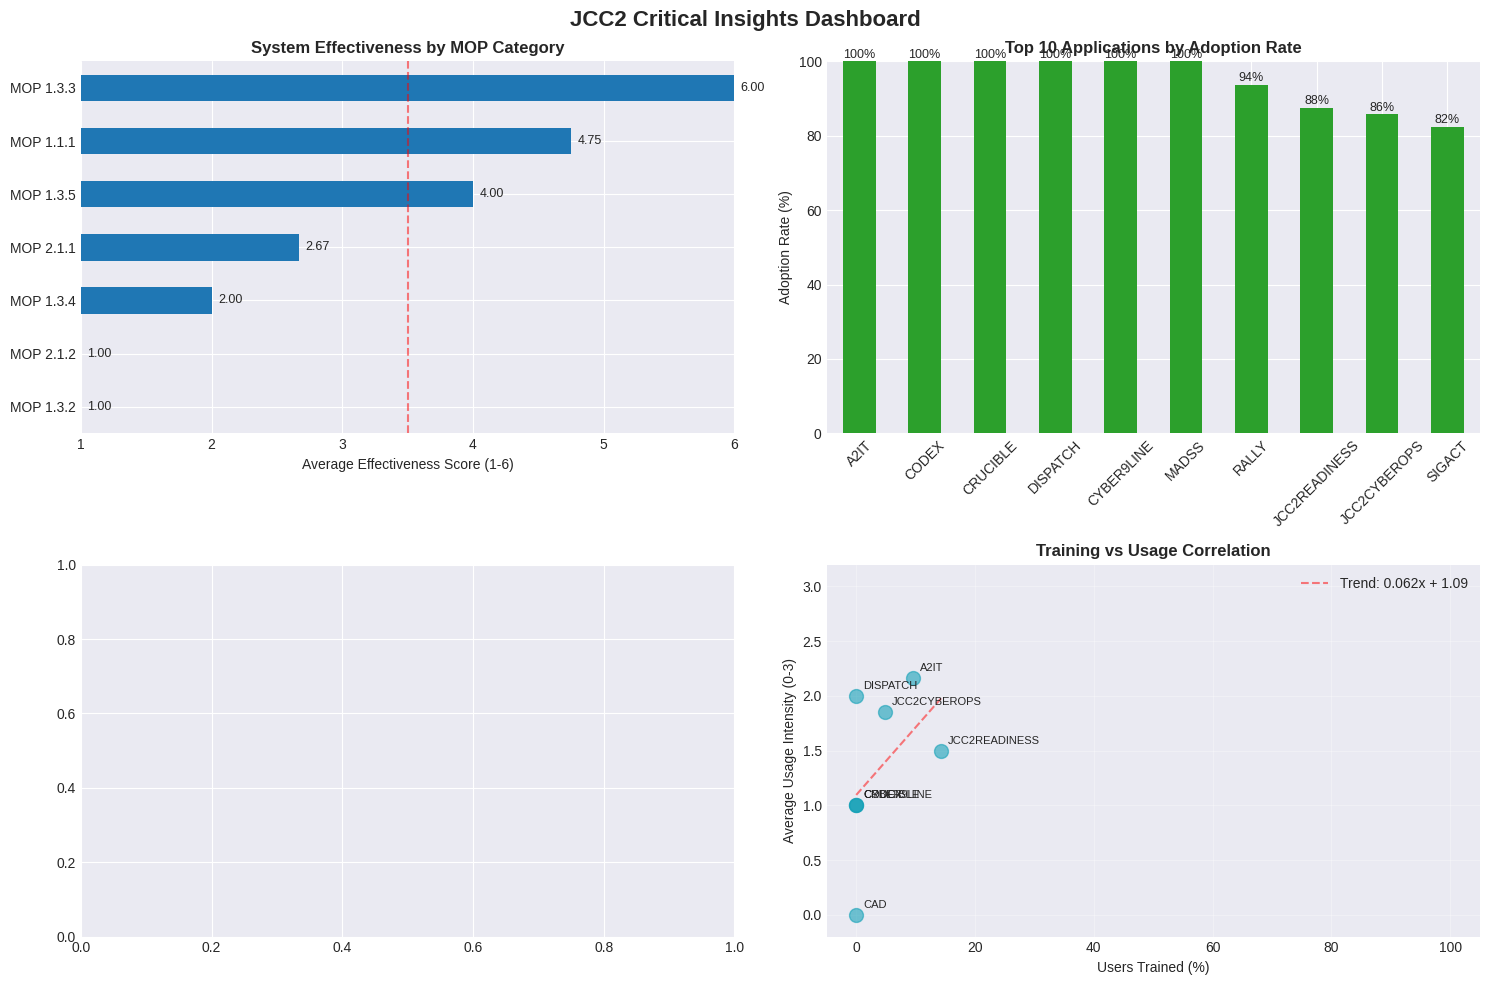

In [16]:
# Create a 2x2 dashboard with the most critical insights
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. System Effectiveness Overview (MOP scores)
mop_scores = {}
effectiveness_map = {'Completely Ineffective': 1, 'Ineffective': 2, 'Somewhat Ineffective': 3,
                    'Somewhat Effective': 4, 'Effective': 5, 'Completely Effective': 6}

for section in processor.sections:
    if section.startswith('mop_'):
        eff_fields = [f for f in processor.sections[section] if 'effectiveness' in f and f in df.columns]
        if eff_fields:
            all_scores = []
            for field in eff_fields:
                scores = df[field].map(effectiveness_map).dropna()
                all_scores.extend(scores.tolist())
            if all_scores:
                section_label = f"MOP {section.replace('mop_', '').replace('_', '.')}"
                mop_scores[section_label] = np.mean(all_scores)

if mop_scores:
    mop_series = pd.Series(mop_scores).sort_values()
    mop_series.plot(kind='barh', ax=ax1, color=COLORS['primary'])
    ax1.set_title('System Effectiveness by MOP Category', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Average Effectiveness Score (1-6)')
    ax1.axvline(3.5, color='red', linestyle='--', alpha=0.5, label='Neutral')
    ax1.set_xlim(1, 6)
    for i, (cat, score) in enumerate(mop_series.items()):
        ax1.text(score + 0.05, i, f'{score:.2f}', va='center', fontsize=9)

# 2. Application Adoption Rate (Top 10)
app_adoption = {}
apps = ['a2it', 'cad', 'codex', 'crucible', 'cyber9line', 'dispatch', 
        'jcc2cyberops', 'jcc2readiness', 'madss', 'rally', 'redmap', 
        'sigact', 'threathub', 'triage', 'unity']

for app in apps:
    freq_field = f'jcc2_application_usage.frequency_{app}'
    if freq_field in df.columns:
        total = df[freq_field].notna().sum()
        never = (df[freq_field] == 'Never').sum()
        if total > 0:
            adoption = (total - never) / total * 100
            app_adoption[app.upper()] = adoption

if app_adoption:
    top_apps = pd.Series(app_adoption).sort_values(ascending=False).head(10)
    top_apps.plot(kind='bar', ax=ax2, color=COLORS['success'])
    ax2.set_title('Top 10 Applications by Adoption Rate', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Adoption Rate (%)')
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='x', rotation=45)
    for i, (app, rate) in enumerate(top_apps.items()):
        ax2.text(i, rate + 1, f'{rate:.0f}%', ha='center', fontsize=9)

# 3. Overall System Evaluation Metrics
eval_metrics = {}

# SUS Score
sus_fields = [f for f in df.columns if f.startswith('overall_system_usability.sus_')]
if len(sus_fields) == 10:
    sus_scores = processor.calculate_sus_scores(df)
    if sus_scores:
        eval_metrics['SUS Score'] = np.mean(sus_scores)

# NPS Score
nps_scores = processor.calculate_nps_score(df)
if nps_scores is not None:
    eval_metrics['NPS'] = nps_scores + 50  # Shift to 0-100 scale

# Recommendation Rate
if 'overall_system_suitability_eval.recommend_jcc2' in df.columns:
    rec_counts = df['overall_system_suitability_eval.recommend_jcc2'].value_counts()
    if rec_counts.sum() > 0:
        eval_metrics['Would Recommend'] = rec_counts.get('Yes', 0) / rec_counts.sum() * 100

# Overall Effectiveness
if 'reporting_and_data_export.overall_reporting_effectiveness' in df.columns:
    eff_counts = df['reporting_and_data_export.overall_reporting_effectiveness'].map(effectiveness_map).dropna()
    if len(eff_counts) > 0:
        eval_metrics['Reporting Effectiveness'] = (eff_counts >= 4).mean() * 100

if eval_metrics:
    eval_series = pd.Series(eval_metrics)
    colors = [COLORS['success'] if v >= 70 else COLORS['warning'] if v >= 50 else COLORS['danger'] 
             for v in eval_series.values]
    
    eval_series.plot(kind='bar', ax=ax3, color=colors)
    ax3.set_title('Overall System Evaluation Metrics', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Score / Percentage')
    ax3.set_ylim(0, 100)
    ax3.axhline(70, color='green', linestyle='--', alpha=0.5, label='Good')
    ax3.axhline(50, color='orange', linestyle='--', alpha=0.5, label='Acceptable')
    ax3.tick_params(axis='x', rotation=45)
    
    for i, (metric, value) in enumerate(eval_series.items()):
        ax3.text(i, value + 1, f'{value:.0f}', ha='center', fontsize=9)

# 4. Training vs Usage Correlation Summary
training_usage_data = []
for app in apps[:8]:  # Top 8 apps for clarity
    freq_field = f'jcc2_application_usage.frequency_{app}'
    train_field = f'jcc2_application_usage.training_received_{app}'
    
    if freq_field in df.columns and train_field in df.columns:
        # Usage intensity (Never=0, Monthly=1, Weekly=2, Daily=3)
        usage_map = {'Never': 0, 'Monthly': 1, 'Weekly': 2, 'Daily': 3}
        avg_usage = df[freq_field].map(usage_map).mean()
        
        # Training percentage
        train_pct = (df[train_field] == 'Yes').mean() * 100
        
        if pd.notna(avg_usage) and pd.notna(train_pct):
            training_usage_data.append({
                'app': app.upper(),
                'usage': avg_usage,
                'training': train_pct
            })

if training_usage_data:
    tu_df = pd.DataFrame(training_usage_data)
    scatter = ax4.scatter(tu_df['training'], tu_df['usage'], 
                         s=100, alpha=0.6, color=COLORS['info'])
    
    for _, row in tu_df.iterrows():
        ax4.annotate(row['app'], (row['training'], row['usage']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add trend line
    z = np.polyfit(tu_df['training'], tu_df['usage'], 1)
    p = np.poly1d(z)
    ax4.plot(tu_df['training'].sort_values(), p(tu_df['training'].sort_values()), 
            "r--", alpha=0.5, label=f'Trend: {z[0]:.3f}x + {z[1]:.2f}')
    
    ax4.set_xlabel('Users Trained (%)')
    ax4.set_ylabel('Average Usage Intensity (0-3)')
    ax4.set_title('Training vs Usage Correlation', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.set_xlim(-5, 105)
    ax4.set_ylim(-0.2, 3.2)

plt.suptitle('JCC2 Critical Insights Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Executive Summary & Recommendations

In [17]:
# Generate executive summary with key findings
print("\n=== EXECUTIVE SUMMARY ===")
print("\n1. DATA QUALITY")
print(f"   - Total responses collected: {len(df)}")
print(f"   - Overall data completion rate: {df.notna().sum().sum() / (len(df) * len(df.columns)) * 100:.1f}%")
print(f"   - Sections with >80% completion: {sum(1 for _, rate in section_completion.items() if rate > 0.8)}")
print(f"   - Sections with <50% completion: {sum(1 for _, rate in section_completion.items() if rate < 0.5)}")

print("\n2. SYSTEM EFFECTIVENESS")
if mop_scores:
    avg_mop = np.mean(list(mop_scores.values()))
    print(f"   - Average MOP effectiveness score: {avg_mop:.2f}/6.0")
    print(f"   - MOP categories rated 'Effective' or better: {sum(1 for score in mop_scores.values() if score >= 4)}/{len(mop_scores)}")
    best_mop = max(mop_scores.items(), key=lambda x: x[1])
    worst_mop = min(mop_scores.items(), key=lambda x: x[1])
    print(f"   - Highest performing: {best_mop[0]} ({best_mop[1]:.2f})")
    print(f"   - Lowest performing: {worst_mop[0]} ({worst_mop[1]:.2f})")

print("\n3. APPLICATION ECOSYSTEM")
if app_adoption:
    print(f"   - Applications tracked: {len(app_adoption)}")
    print(f"   - Apps with >50% adoption: {sum(1 for rate in app_adoption.values() if rate > 50)}")
    print(f"   - Average adoption rate: {np.mean(list(app_adoption.values())):.1f}%")
    if top_apps is not None and len(top_apps) > 0:
        print(f"   - Most adopted app: {top_apps.index[0]} ({top_apps.iloc[0]:.0f}%)")

print("\n4. USER SATISFACTION")
if 'SUS Score' in eval_metrics:
    sus = eval_metrics['SUS Score']
    print(f"   - System Usability Score (SUS): {sus:.1f}/100")
    print(f"   - SUS Rating: {'Excellent' if sus >= 80 else 'Good' if sus >= 68 else 'OK' if sus >= 50 else 'Poor'}")
if 'NPS' in eval_metrics:
    print(f"   - Net Promoter Score: {eval_metrics['NPS']-50:.0f}")
if 'Would Recommend' in eval_metrics:
    print(f"   - Would recommend JCC2: {eval_metrics['Would Recommend']:.1f}%")

print("\n5. KEY INSIGHTS")
# Training correlation
if training_usage_data and len(tu_df) > 3:
    correlation = tu_df['training'].corr(tu_df['usage'])
    print(f"   - Training-Usage Correlation: {correlation:.3f} ({'Positive' if correlation > 0 else 'Negative'})")

# Cyber operator participation
if 'role_and_echelon.is_cyber_operator' in df.columns:
    cyber_pct = (df['role_and_echelon.is_cyber_operator'] == 'Yes').mean() * 100
    print(f"   - Cyber operator participation: {cyber_pct:.1f}%")

# Response timeline
if 'user_information.date' in df.columns:
    date_range_days = (pd.to_datetime(df['user_information.date'].max()) - 
                      pd.to_datetime(df['user_information.date'].min())).days
    print(f"   - Data collection period: {date_range_days} days")

print("\n=== RECOMMENDATIONS ===")
recommendations = []

# Based on completion rates
low_completion_sections = [s for s, rate in section_completion.items() if rate < 0.5]
if low_completion_sections:
    recommendations.append(f"1. Improve data collection for {len(low_completion_sections)} sections with <50% completion")

# Based on effectiveness scores
if mop_scores and avg_mop < 4:
    recommendations.append(f"2. Focus improvement efforts on MOP categories scoring below 4.0")

# Based on training
if training_usage_data and correlation > 0.3:
    low_training_apps = [d['app'] for d in training_usage_data if d['training'] < 30]
    if low_training_apps:
        recommendations.append(f"3. Increase training for {', '.join(low_training_apps[:3])} (strong usage correlation)")

# Based on adoption
if app_adoption:
    low_adoption = [app for app, rate in app_adoption.items() if rate < 20]
    if low_adoption:
        recommendations.append(f"4. Review and improve adoption for {len(low_adoption)} applications with <20% usage")

# Based on SUS score
if 'SUS Score' in eval_metrics and eval_metrics['SUS Score'] < 68:
    recommendations.append("5. Prioritize usability improvements to reach 'Good' SUS rating (68+)")

for rec in recommendations:
    print(f"   {rec}")


=== EXECUTIVE SUMMARY ===

1. DATA QUALITY
   - Total responses collected: 21
   - Overall data completion rate: 35.5%
   - Sections with >80% completion: 3
   - Sections with <50% completion: 21

2. SYSTEM EFFECTIVENESS
   - Average MOP effectiveness score: 3.06/6.0
   - MOP categories rated 'Effective' or better: 3/7
   - Highest performing: MOP 1.3.3 (6.00)
   - Lowest performing: MOP 1.3.2 (1.00)

3. APPLICATION ECOSYSTEM
   - Applications tracked: 15
   - Apps with >50% adoption: 12
   - Average adoption rate: 77.8%
   - Most adopted app: A2IT (100%)

4. USER SATISFACTION

5. KEY INSIGHTS
   - Training-Usage Correlation: 0.482 (Positive)
   - Cyber operator participation: 81.0%
   - Data collection period: 2 days

=== RECOMMENDATIONS ===
   1. Improve data collection for 21 sections with <50% completion
   2. Focus improvement efforts on MOP categories scoring below 4.0
   3. Increase training for A2IT, CAD, CODEX (strong usage correlation)
   4. Review and improve adoption for 1

## 5. Data Export Summary

In [18]:
# Create exportable summary data
summary_export = {
    'metadata': {
        'generated_date': current_date,
        'total_responses': len(df),
        'total_fields': len(df.columns),
        'data_range': f"{df['user_information.date'].min()} to {df['user_information.date'].max()}"
    },
    'overall_metrics': metrics_df.to_dict('records'),
    'section_metrics': section_metrics_df.to_dict('records'),
    'key_scores': {
        'average_mop_effectiveness': avg_mop if 'avg_mop' in locals() else None,
        'sus_score': eval_metrics.get('SUS Score'),
        'nps_score': eval_metrics.get('NPS', 50) - 50 if 'NPS' in eval_metrics else None,
        'recommendation_rate': eval_metrics.get('Would Recommend'),
        'average_completion_rate': df.notna().sum().sum() / (len(df) * len(df.columns)) * 100
    }
}

# Save summary
import json
with open('jcc2_executive_summary.json', 'w') as f:
    json.dump(summary_export, f, indent=2)

print("\n=== SUMMARY DATA EXPORTED ===")
print("Summary data has been exported to: jcc2_executive_summary.json")
print("\nThis executive summary notebook provides a compressed view of:")
print("- Overall data quality and response metrics")
print("- Key metrics for each major section")
print("- Critical insights across 4 key dimensions")
print("- Executive summary with actionable recommendations")
print("- Exportable summary data for reporting")


=== SUMMARY DATA EXPORTED ===
Summary data has been exported to: jcc2_executive_summary.json

This executive summary notebook provides a compressed view of:
- Overall data quality and response metrics
- Key metrics for each major section
- Critical insights across 4 key dimensions
- Executive summary with actionable recommendations
- Exportable summary data for reporting
